In [38]:
%matplotlib inline
import sys
import numpy as np
import os
import pickle
import h5py
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42 # allow for editable text in Illustrator
matplotlib.rcParams['ps.fonttype'] = 42  # allow for editable text in Illustrator
import seaborn as sb
import glob
import pandas as pd

In [39]:
basedir = '/cluster/work/grlab/projects/metagenome/data/gtex/queries/trans_exons'
align_dir = '/cluster/work/grlab/projects/metagenome/data/gtex/alignments_star_trans_exons/results/alignments'
file_metadata = '/cluster/work/grlab/projects/GTEx/metadata/SraRunTable_20180218.txt'
file_trans_exons = os.path.join(basedir, 'gencode.v30.trans_exons_all_hits.result_samples.txt')
plotdir = '/cluster/work/grlab/projects/metagenome/data/gtex/plots/trans_exons'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)

In [40]:
### get metadata
metadata = pd.read_csv(file_metadata, delimiter='\t', index_col=16)

In [41]:
metadata.loc['SRR2135286']['AvgSpotLen']

101

In [42]:
### collect results
hits2samples = dict()
samples2hits = dict()
all_samples = []
all_trans = set()
excluded = set()
for line in open(file_trans_exons, 'r'):
    ### ignore comments
    if line[0] == '[':
        continue
    sl = line.strip().split('\t')
    ### no hits found
    if len(sl) < 3:
        for s in sl[1].split(';'):
            excluded.add(s)
        continue
    all_trans.add(sl[1].split(';')[0])
    ### ignore hits that occur in more than 1K samples
    if len(sl) > 1000:
        continue
    for s in sl[2:]:
        cs = s.split(':')[0][1:-1]
        all_samples.append(cs)
        try:
            samples2hits[cs].append(sl[1])
        except KeyError:
            samples2hits[cs] = [sl[1]]
        try: 
            hits2samples[sl[1]].append(cs)
        except KeyError:
            hits2samples[sl[1]] = [cs]

In [43]:
### collect support counts
read_counts = []
for sample in samples2hits:
    if not os.path.exists(os.path.join(align_dir, '%s.hits' % sample)):
        continue
    for t in samples2hits[sample]:
        flist = glob.glob(os.path.join(align_dir, '%s.hits' % sample, '%s.all.%s.*.cnt' % (sample, t)))
        if len(flist) == 0:
            continue
        assert len(flist) == 2
        curr_count = 0
        for fname in flist:
            for line in open(fname, 'r'):
                curr_count += int(line.strip())
        read_counts.append(curr_count)

In [44]:
### load flanking counts
read_counts_downstream, read_counts_upstream = pickle.load(open(os.path.join(basedir, 'flanking_counts.pickle'), 'rb'))

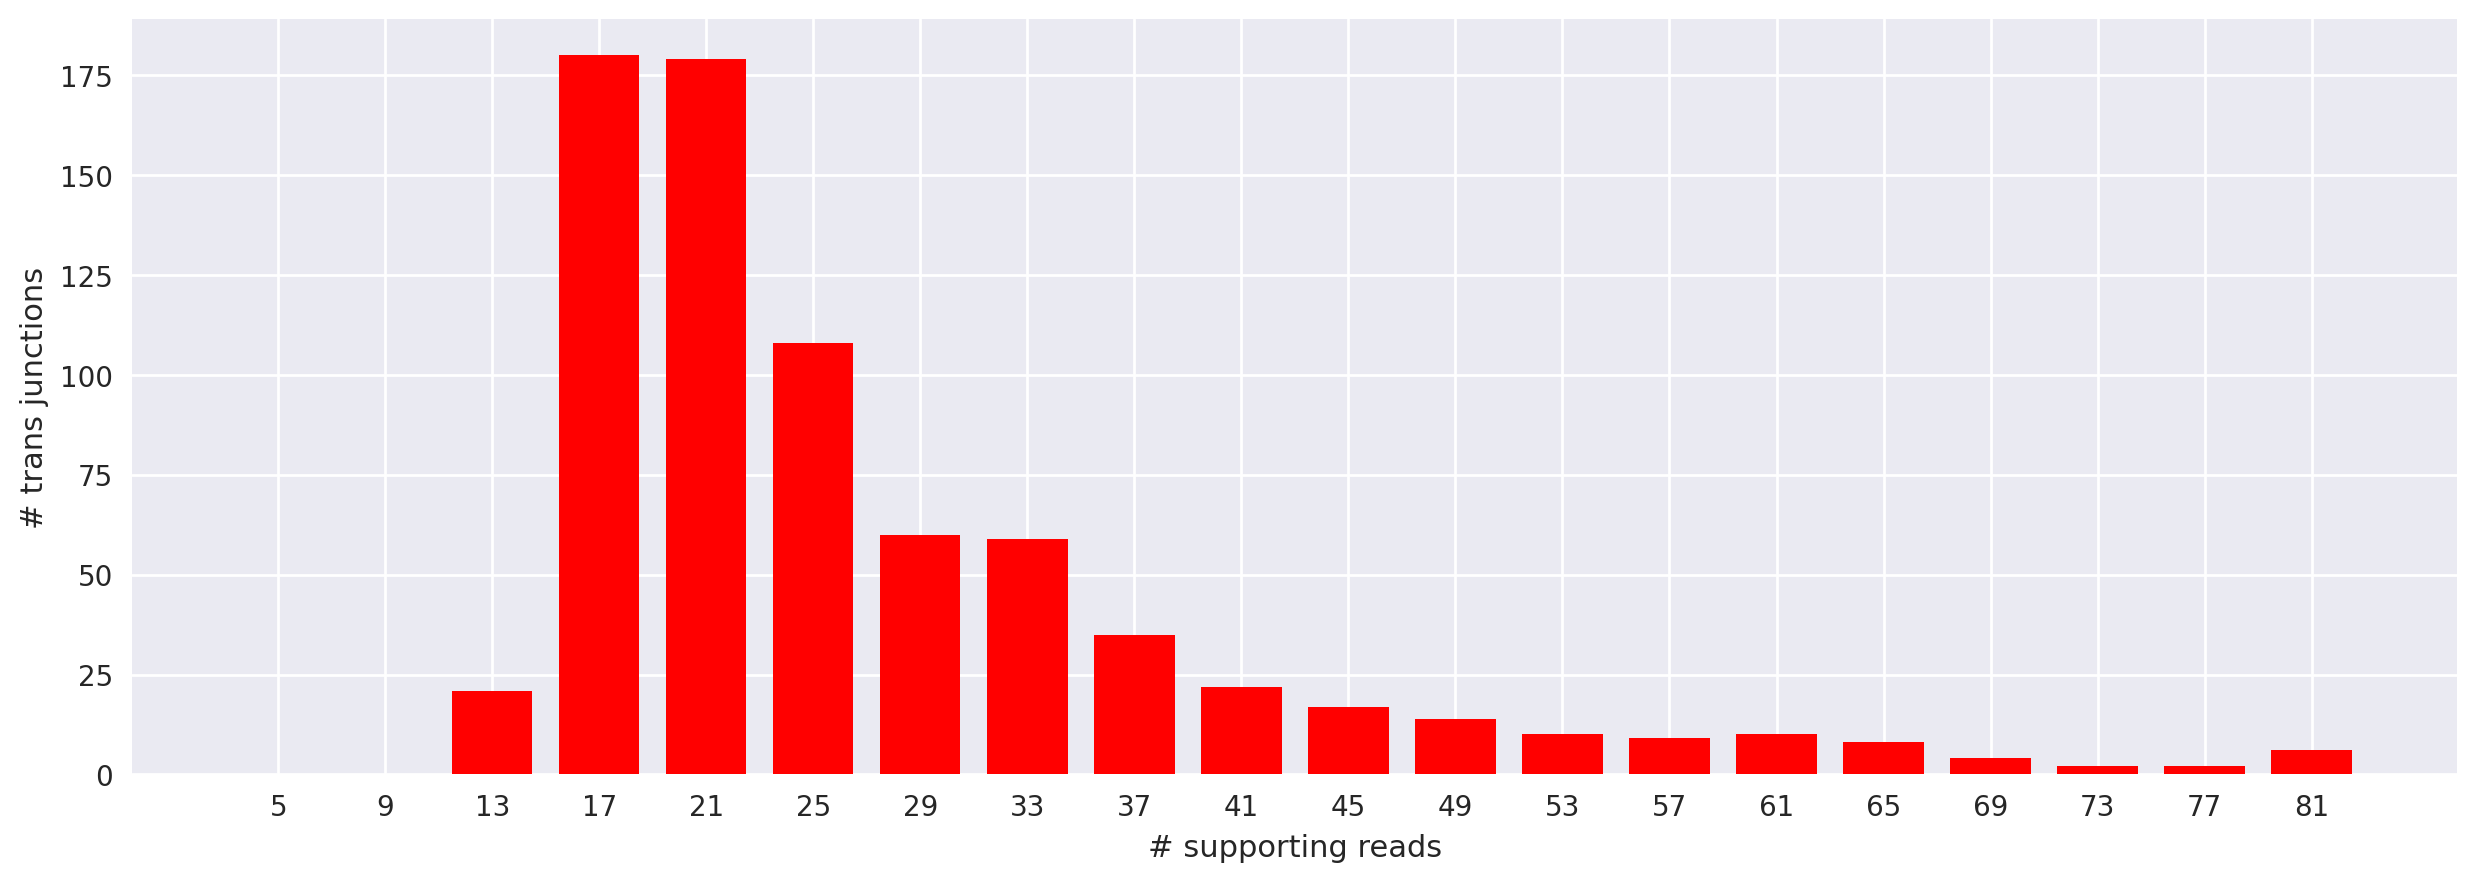

In [45]:
### plot read support distribution trans junctions
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(15,5), dpi=200)
    ax = fig.add_subplot(111)
    h = np.histogram(read_counts, range=(1, 81), bins=20)
    ax.bar(h[1][1:], h[0], width=3, color='r')
    ax.set_xticks(h[1][1:])
    ax.set_ylabel('# trans junctions')
    ax.set_xlabel('# supporting reads')
    plt.savefig(os.path.join(plotdir, 'trans_junction_read_support.png'), format='png', bbox_inches='tight')
    plt.savefig(os.path.join(plotdir, 'trans_junction_read_support.pdf'), format='pdf', bbox_inches='tight')

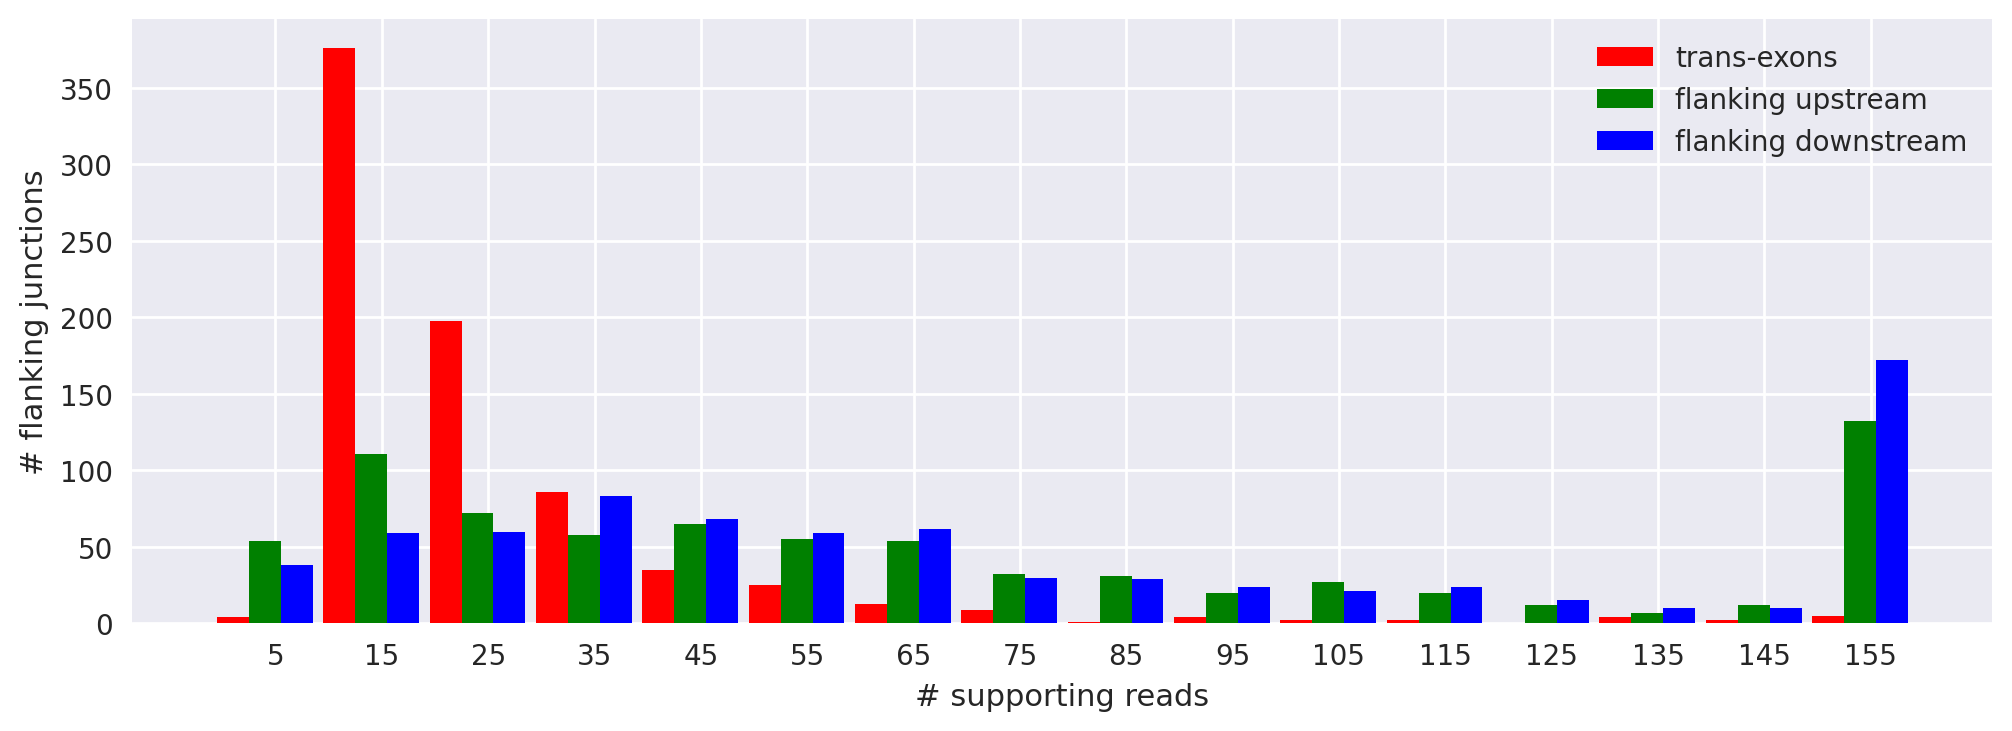

In [50]:
### plot read support distribution flanking junctions
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(12,4), dpi=200)
    ax = fig.add_subplot(111)
    bins = np.linspace(1, 151, 16)
    bins = np.append(bins, [1000000])
    h = np.histogram(read_counts, bins=bins)
    ax.bar(h[1][:-1], h[0], width=3, color='r', label='trans-exons')
    h = np.histogram(read_counts_upstream, bins=bins)
    ax.bar(h[1][:-1]+ 3, h[0], width=3, color='g', label='flanking upstream')
    h = np.histogram(read_counts_downstream, bins=bins)
    ax.bar(h[1][:-1] + 6, h[0], width=3, color='b', label='flanking downstream')
    ax.set_xticks(h[1][:-1] + 4)
    ax.set_ylabel('# flanking junctions')
    ax.set_xlabel('# supporting reads')
    plt.legend()
    plt.savefig(os.path.join(plotdir, 'flanking_junction_read_support.png'), format='png', bbox_inches='tight')
    plt.savefig(os.path.join(plotdir, 'flanking_junction_read_support.pdf'), format='pdf', bbox_inches='tight')

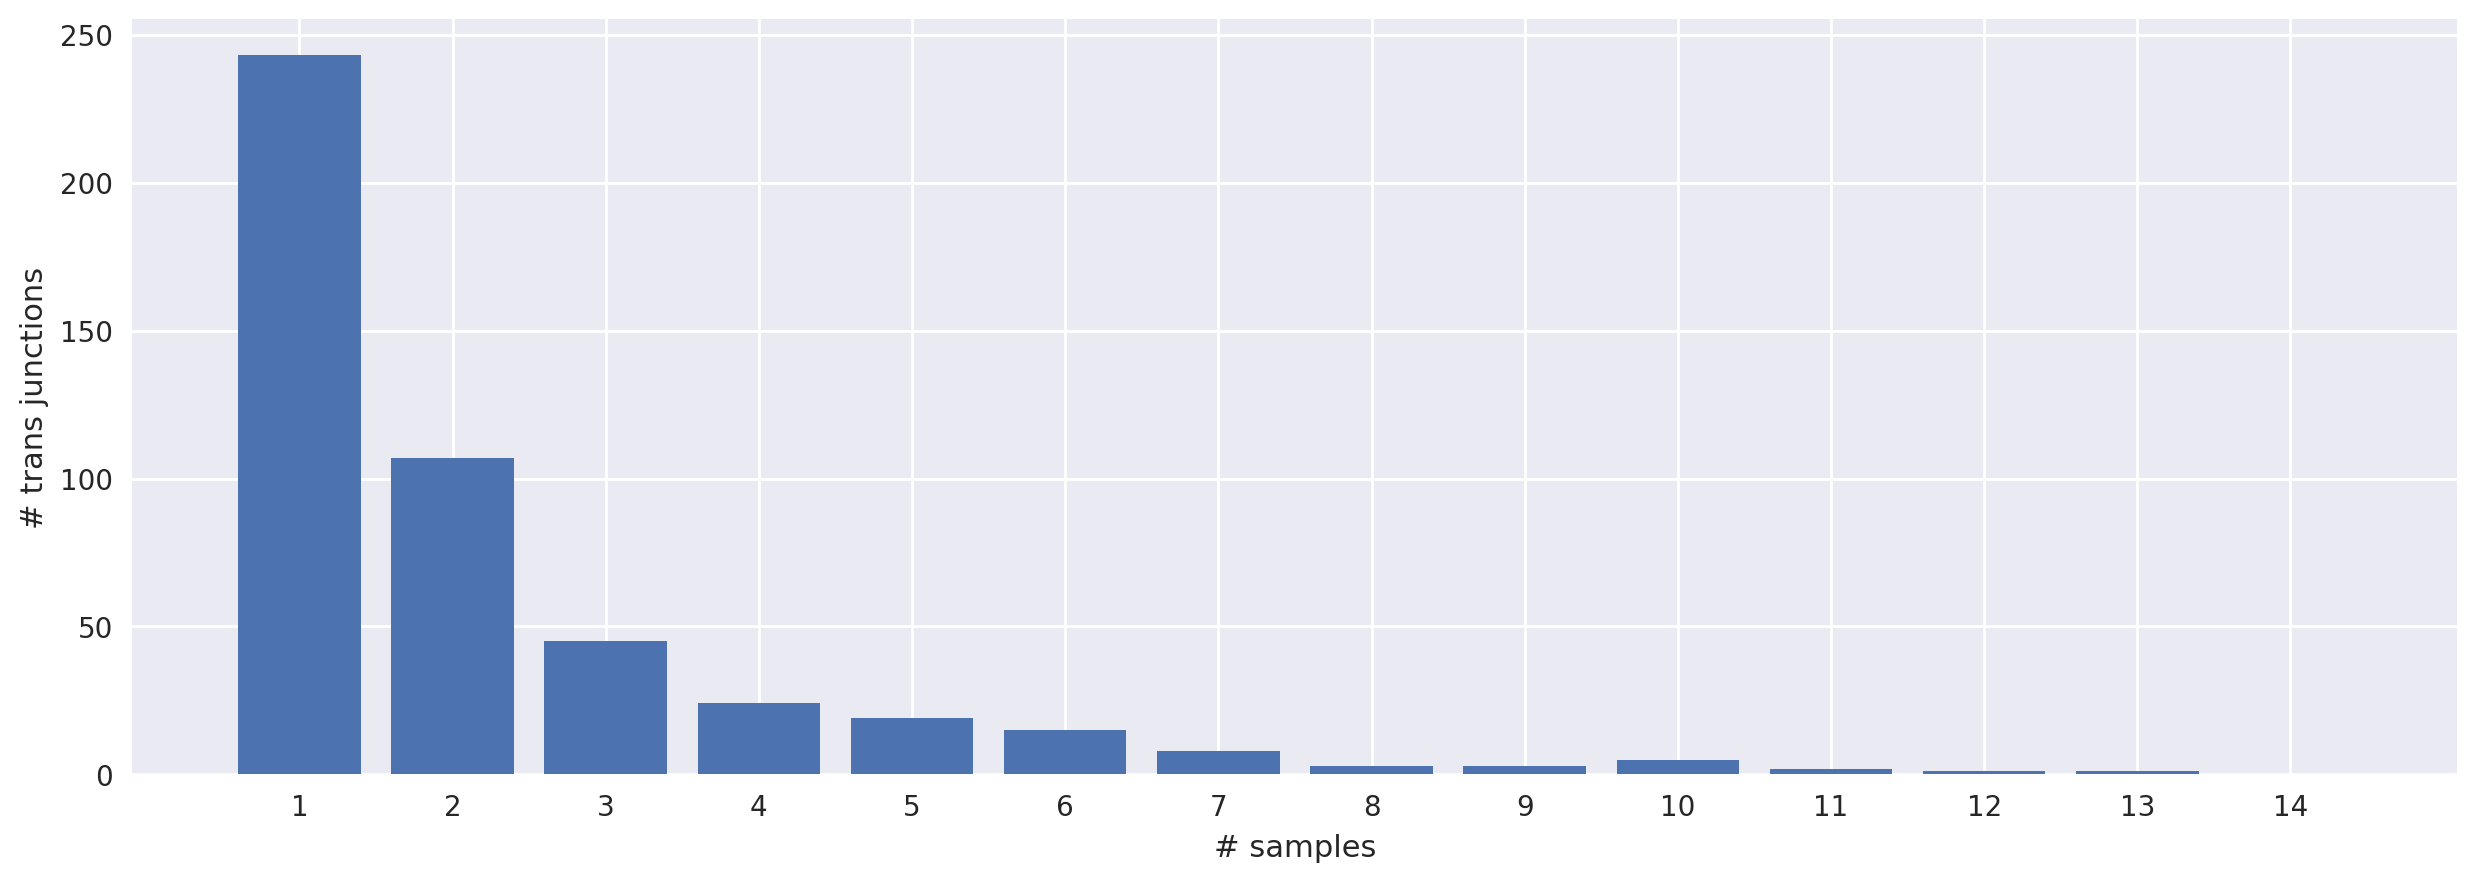

In [47]:
### plot distribution of samples across hits
count = [len(hits2samples[_]) for _ in hits2samples]
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(15,5), dpi=200)
    ax = fig.add_subplot(111)
    h = np.histogram(count, range=(1,15), bins=14)
    ax.bar(np.arange(1, 15), h[0])
    ax.set_xticks(np.arange(1, 15))
    ax.set_ylabel('# trans junctions')
    ax.set_xlabel('# samples')
    plt.savefig(os.path.join(plotdir, 'samples_per_trans_junction.png'), format='png', bbox_inches='tight')
    plt.savefig(os.path.join(plotdir, 'samples_per_trans_junction.pdf'), format='pdf', bbox_inches='tight')

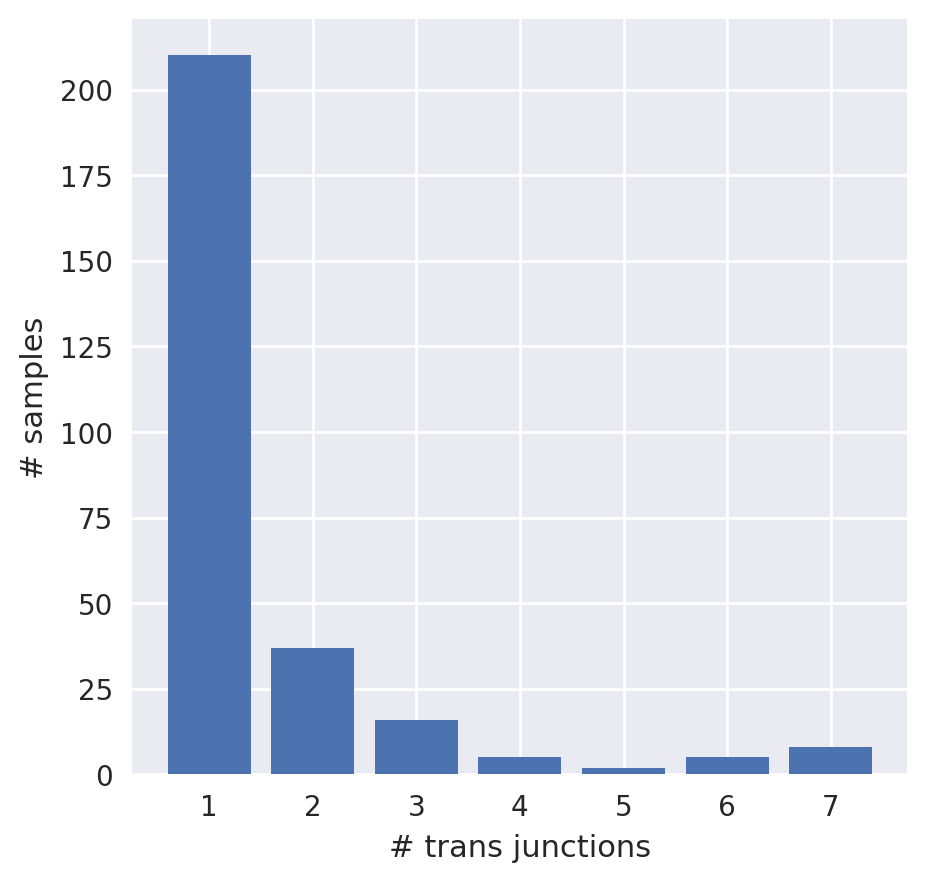

In [48]:
### plot distribution of samples across hits
count = [len(samples2hits[_]) for _ in samples2hits]
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(5,5), dpi=200)
    ax = fig.add_subplot(111)
    h = np.histogram(count, range=(1,8), bins=7)
    ax.bar(np.arange(1, 8), h[0])
    ax.set_xticks(np.arange(1, 8))
    ax.set_ylabel('# samples')
    ax.set_xlabel('# trans junctions')
    plt.savefig(os.path.join(plotdir, 'trans_junction_per_sample.png'), format='png', bbox_inches='tight')
    plt.savefig(os.path.join(plotdir, 'trans_junction_per_sample.pdf'), format='pdf', bbox_inches='tight')

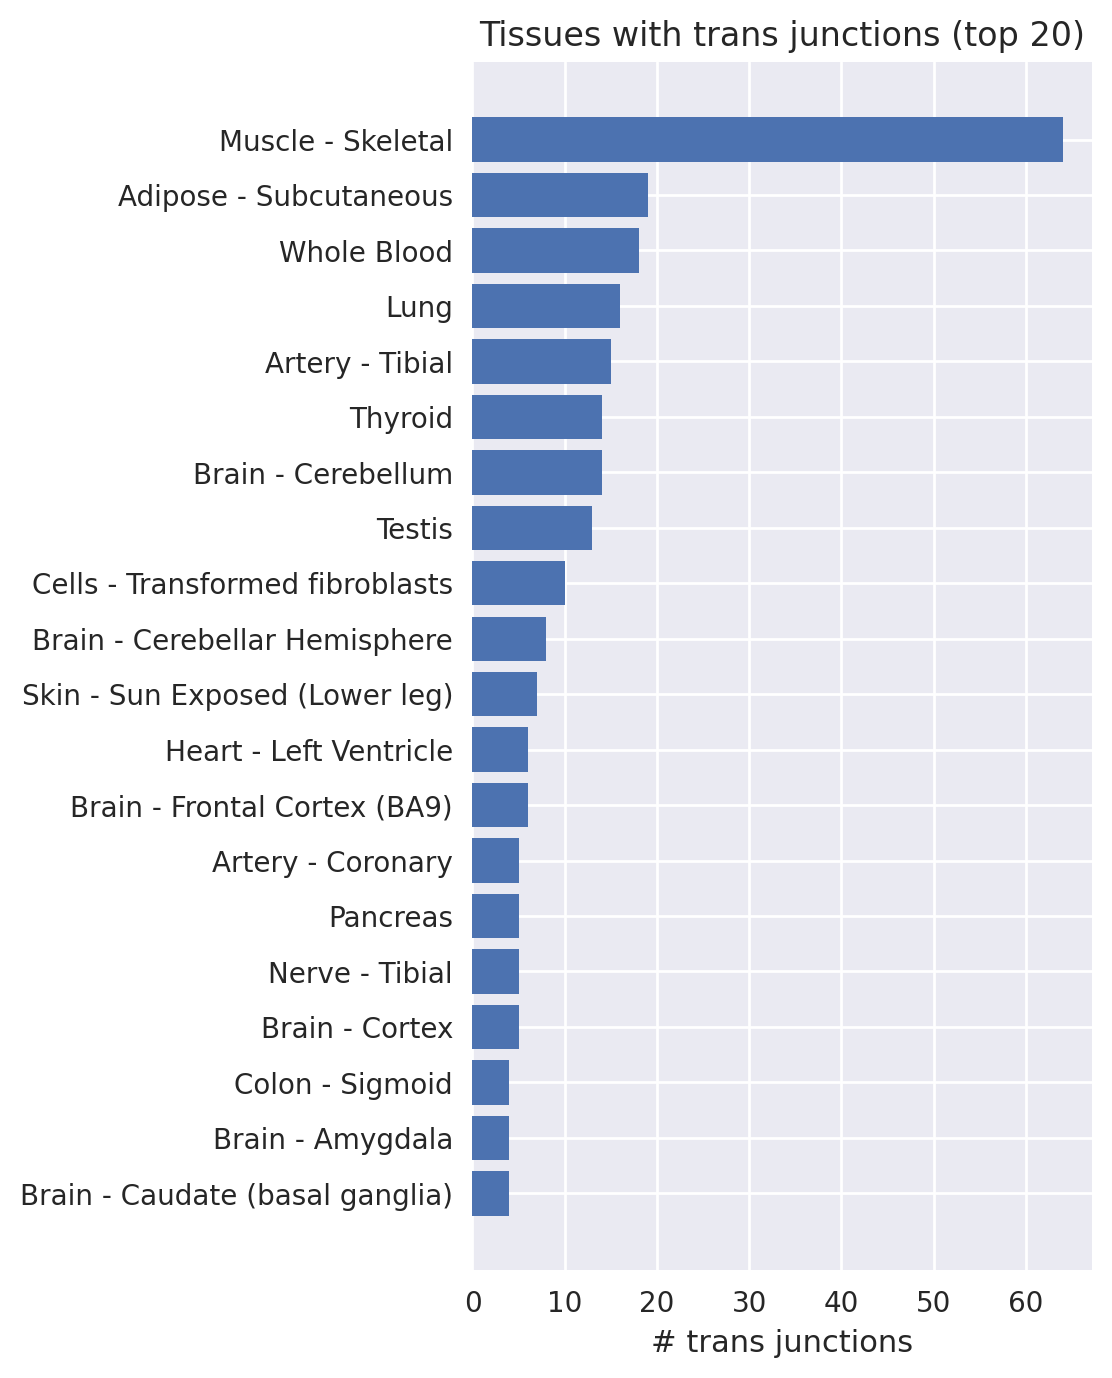

In [49]:
### associate hits with tissues
tissues = [metadata.loc[_]['body_site'] for _ in np.unique(all_samples)]
tissues_u, tissues_c = np.unique(tissues, return_counts=True)
s_idx = np.argsort(tissues_c)[-20:]
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(4,8), dpi=200)
    ax = fig.add_subplot(111)
    ax.barh(np.arange(s_idx.shape[0]), tissues_c[s_idx])
    ax.set_yticks(np.arange(s_idx.shape[0]))
    ax.set_yticklabels(tissues_u[s_idx])
    #ax.set_ylabel('# samples')
    ax.set_xlabel('# trans junctions')
    ax.set_title('Tissues with trans junctions (top 20)')
    plt.savefig(os.path.join(plotdir, 'trans_junction_top_tissues.png'), format='png', bbox_inches='tight')
    plt.savefig(os.path.join(plotdir, 'trans_junction_top_tissues.pdf'), format='pdf', bbox_inches='tight')